# Notebook made by  

__Name(s)__: Afra Baas & Stijn Hamerslag & Isa-Ali Kirca & Juno Prent

__Student id(s)__ : 12417505 & 1323795 & 12014672 & 11915307


__This notebook has been made to plot the results with the metric which is the most comparable to the plot of the authors (last accuracy/parity/bias). Please keep in mind that:__

> This is only applicable if the provided datasets are used (german, compas and drug).

> Plots can onle be made if all the datasets together with all their attacks have been run with epsilons from 0.0 up to 1, otherwise it will most likely throw errors.

In [1]:
import glob
import csv
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [5]:
# seed still needs to be implemented
def get_test_dicts(dataset, data_choice, methods, folder_measure, measure):
    # make the dicts
    last_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    # find all the files for the dataset
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, folder_measure)):
        for method in methods:
            if method in file_name:
                # strip the methods (/IAF-) etc. 
                meth = method[1:-1]
                splits = file_name.split("_")
                # find the epsilon in the filename 
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                # if there are nans in the data, skip them
                measured = data[~data[measure].isna()][measure]
                
                if measure == "test_acc":
                    # calculate test error
                    last_dict[meth][epsilon] = 1 - measured[measured.index[-1]]
                    
                else:
                    last_dict[meth][epsilon] = measured[measured.index[-1]] 

    return last_dict 


# same holds for this function, but this time we save the iterations and time taken
# which you have to run once for the time and one for the iterations
def get_time_and_it_dicts(dataset, data_choice, methods, time_and_it_folder, t_i_col):
    dict_ = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, time_and_it_folder)):
        for method in methods:
            if method in file_name:
                meth = method[1:-1]
                splits = file_name.split("_")
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                measured = data[~data[t_i_col].isna()][t_i_col]
                
                dict_[meth][epsilon] = measured[measured.index[-1]]
    return dict_

In [108]:
def plot_seed(datasets, data_choice, methods, folder_measure, measure, time_and_it, t_i_col):    
    # ta = test accuracy
    german_last_ta_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[0], measures[0])
    compas_last_ta_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[0], measures[0])
    drug_last_ta_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[0], measures[0])
    
    
    # concat all three dicts into one df
    acc_df = pd.concat({'German': pd.DataFrame(german_last_ta_dict), 
                        'COMPAS': pd.DataFrame(compas_last_ta_dict), 
                        'Drug consumption': pd.DataFrame(drug_last_ta_dict)}).unstack(0).sort_index(axis = 0)
    

    # p = parity
    german_last_p_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[1])
    compas_last_p_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[1])
    drug_last_p_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[1])
    
    # concat all three dicts into one df
    p_df = pd.concat({'German': pd.DataFrame(german_last_p_dict), 
                      'COMPAS': pd.DataFrame(compas_last_p_dict), 
                      'Drug consumption': pd.DataFrame(drug_last_p_dict)}).unstack(0).sort_index(axis = 0)

    # b = biases
    german_last_b_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[2])
    compas_last_b_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[2])
    drug_last_b_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[2])
    
    # concat all three dicts into one df
    b_df = pd.concat({'German': pd.DataFrame(german_last_b_dict), 
                      'COMPAS': pd.DataFrame(compas_last_b_dict), 
                      'Drug consumption': pd.DataFrame(drug_last_b_dict)}).unstack(0).sort_index(axis = 0)
    
    # to be able to make a plot loop
    dfs = [acc_df, p_df, b_df]
    
    ylabels = ["Test error", "Statistical parity", "Equality of opportunity"]
    lines = ['b-s', 'g-^', 'r-D']
    fig, axs = plt.subplots(3,3, figsize=(15, 10))
    axs = axs.ravel()
    
    fig.suptitle("{}".format(data_choice), fontsize=20, fontweight='heavy')
    
    for i in range(9):
        a = 0
        for j in range(0,9,3):
            t = i % 3
            
            # makes sure everything works as it has to
            if i <= 2:
                j += 0
            elif i > 2 and i <= 5:
                j += 1  
            elif i > 5:
                j += 2
                
            col = dfs[t].columns[j]
            column_data = dfs[t][col]

            axs[i].plot(column_data, lines[a], label="{}".format(column_data.name[0]))
            axs[i].set_title("{}".format(column_data.name[1]), fontweight='bold')
            axs[i].set_xlabel('Epsilon', fontweight='heavy')
            
            if "acc" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[0], fontweight='heavy')
            elif "par" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[1], fontweight='heavy')
            else:
                axs[i].set_ylabel(ylabels[2], fontweight='heavy')
            
            axs[i].legend(loc=9, ncol=3)
            axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]) 
            axs[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, ""])
    
            a += 1
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)
    plt.show()
    
    # show time taken and number of iterations in a dataframe
    time_taken_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], 
                                         data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    
    
    last_iter_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    
    german_df = pd.concat({"Time (s)":time_taken_g, "# iters":last_iter_g}).unstack(0)
    compas_df = pd.concat({"Time (s)":time_taken_c, "# iters":last_iter_c}).unstack(0)
    drug_df = pd.concat({"Time (s)":time_taken_d, "# iters":last_iter_d}).unstack(0)
    
    display(pd.concat({"German": german_df, "COMPAS": compas_df, "Drug consumption": drug_df}))
    
#     display(pd.concat({"Time taken in seconds": time_taken, "Number of iterations": last_iter}).unstack(0))
#     print()

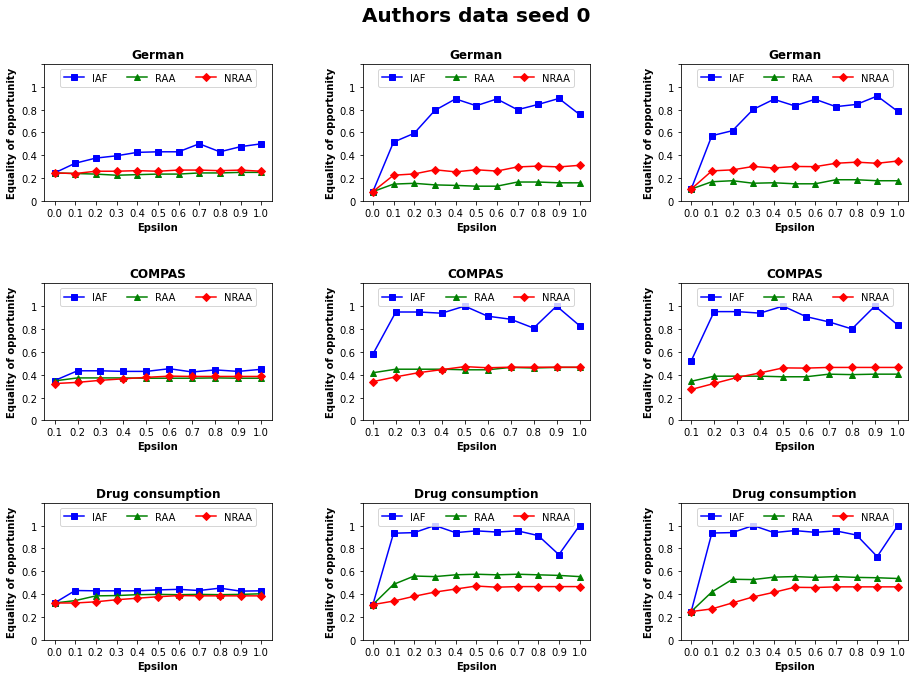

IAF                RAA                NRAA  \
                        Time (s) # iters   Time (s) # iters    Time (s)   
German           0.1  119.963383    88.0  28.663473    28.0   66.428201   
                 0.2  132.571073    88.0  27.531006    28.0   70.833265   
                 0.3  146.628987    98.0  26.328007    28.0   66.408511   
                 0.4  135.203009    88.0  29.704707    28.0   64.083476   
                 0.5  163.420735   108.0  29.940431    28.0   72.289199   
                 0.6  204.513587   138.0  33.301365    28.0   65.158239   
                 0.7  216.206778   148.0  31.091233    28.0   64.106989   
                 0.8  225.896214   158.0  27.387768    28.0   66.646995   
                 0.9  190.512131   138.0  27.629340    28.0   60.396366   
                 1.0  191.816256   138.0  27.094062    28.0   68.720471   
COMPAS           0.1   66.236904    78.0  24.636540    28.0  185.351200   
                 0.2   51.599164    58.0  23.912830    28.0  210.060155   
                 0.3   75.812545    98.0  20.296671    28.0  189.372537   
                 0.4   67.443183    88.0  22.951269    28.0  182.230510   
                 0.5   25.165166    28.0  17.191107    28.0  181.797261   
                 0.6  104.599977   108.0  15.862599    28.0  183.333268   
                 0.7   66.792494    68.0  24.559738    28.0  176.680843   
                 0.8   49.638801    48.0  22.466474    28.0  212.390266   
                 0.9   49.560540    48.0  22.069595    28.0  191.224286   
                 1.0   71.005558    68.0  26.146106    28.0  188.505907   
Drug consumption 0.1  101.497600   128.0  19.583493    28.0  179.451213   
                 0.2   82.208161    98.0  20.073849    28.0  178.612645   
                 0.3   26.856711    28.0  21.271935    28.0  178.175997   
                 0.4   42.442700    48.0  19.715801    28.0  188.967008   
                 0.5   94.569588    98.0  20.400668    28.0  183.385596   
                 0.6   74.772693    78.0  22.578197    28.0  185.545095   
                 0.7   39.974586    38.0  23.280982    28.0  192.140367   
                 0.8   50.822375    48.0  28.948147    28.0  182.678054   
                 0.9   49.898632    48.0  27.263154    28.0  188.253011   
                 1.0   44.229064    48.0  23.727572    28.0  187.298024   

                              
                     # iters  
German           0.1    28.0  
                 0.2    28.0  
                 0.3    28.0  
                 0.4    28.0  
                 0.5    28.0  
                 0.6    28.0  
                 0.7    28.0  
                 0.8    28.0  
                 0.9    28.0  
                 1.0    28.0  
COMPAS           0.1    28.0  
                 0.2    28.0  
                 0.3    28.0  
                 0.4    28.0  
                 0.5    28.0  
                 0.6    28.0  
                 0.7    28.0  
                 0.8    28.0  
                 0.9    28.0  
                 1.0    28.0  
Drug consumption 0.1    28.0  
                 0.2    28.0  
                 0.3    28.0  
                 0.4    28.0  
                 0.5    28.0  
                 0.6    28.0  
                 0.7    28.0  
                 0.8    28.0  
                 0.9    28.0  
                 1.0    28.0

In [109]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)

Make sure you **change the data_choice** (original data or authors data). So only the second parameter of plot_seed. The model automatically saves the data choice as:

    - dataset_choice: x seed y
    
with:

**x**: $\left\{\begin{array}{l}\text{Original data} \;\;\;\;\;\; \text { if  x == --original_data y} \;\; \text{OR} \;\; \text{x == --original_data yes} \\ \text{Authors data} \;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**y**: $\left\{\begin{array}{l}y \in \{1,2,3\} \;\;\;\;\;\; \text { if  y == --rand_seed 1} \;\; \text{OR} \;\; \text{y == --rand_seed 2} \;\; \text{OR} \;\; \text{y == --rand_seed 3} \\ \text{0} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text { otherwise }\end{array}\right.$

In [110]:
methods = ["/IAF-", "/RAA-", "/NRAA-"]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [104]:
# Make sure to change the second parameter, i.e. the string 

# plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
#           time_and_it, time_and_it_columns)

In [132]:
import glob

dataset_names = ["data.npz", "german_group_label.npz", "compas_data.npz", "compas_group_label.npz", "drug2_data.npz", "drug2_group_label.npz"]

for i in glob.glob(os.path.join("..", "original_data", "*")):
    print(i.split(os.path.join("original_data", " ").strip())[1])
#      if i.split("original_data/")[1] in dataset_names:
#             print("YEs")

make_datasets_notebook.ipynb
make_datasets.py
resources
compas_data.npz
__init__.py
__pycache__
drug2_data.npz
compas_group_label.npz
german_group_label.npz
data.npz
drug2_group_label.npz
